In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from GaussianCopulaImp.gaussian_copula import GaussianCopula
from GaussianCopulaImp.low_rank_gaussian_copula import LowRankGaussianCopula
from GaussianCopulaImp.helper_data_generation import generate_sigma, generate_mixed_from_gc, generate_LRGC
from GaussianCopulaImp.helper_evaluation import get_rmse, get_mae, error_by_reliability
from GaussianCopulaImp.helper_mask import mask

## Confidence interval under full rank Gaussian copula model

We use a 2000*15 dimensional dataset generated from the Gaussian copula model whose marginals are exponential distribution with rate parameter 1/3. The coverage results are robust to different marginal distribution specification.

In [3]:
seed = 101
var_types = {'cont':list(range(15)), 'ord':[], 'bin':[]}
n = 2000

In [4]:
sigma = generate_sigma(seed, p=sum([len(value) for value in var_types.values()]))
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask(X, mask_fraction=0.4, seed=seed)

In [5]:
model = GaussianCopula()

In [6]:
out = model.impute_missing(X=X_masked,verbose=True)

Copula correlation change ratio:  0.1247
Copula correlation change ratio:  0.068
Copula correlation change ratio:  0.0383
Copula correlation change ratio:  0.0233
Copula correlation change ratio:  0.0153
Copula correlation change ratio:  0.0107
Convergence at iteration 7


In [7]:
get_rmse(x_imp = out['imputed_data'], x_true = X, x_obs = X_masked, relative = True)

0.5222093777725176

In [8]:
cover_rate = {}
for alpha in [0.85, 0.9, 0.95]:
    out_confidence_interval = model.get_imputed_confidence_interval(alpha = alpha)
    missing_loc = np.isnan(X_masked)
    lower, upper = out_confidence_interval['lower'], out_confidence_interval['upper']
    cover = (lower[missing_loc] < X[missing_loc]) & (upper[missing_loc] > X[missing_loc])
    cover_rate[alpha] = np.array(cover).mean()

The returned confidence intervals are slightly higher than the specified coverage rate

In [9]:
for key, val in cover_rate.items():
    print(f'The actual coverage rate is {val:.3f} with specified coverage rate {key:.3f}')

The actual coverage rate is 0.881 with specified coverage rate 0.850
The actual coverage rate is 0.922 with specified coverage rate 0.900
The actual coverage rate is 0.965 with specified coverage rate 0.950


## Reliability for continuous data under full rank Gaussian copula model

In [10]:
reliability = model.get_reliability(Ximp = out['imputed_data'])

In [11]:
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=out['imputed_data'])

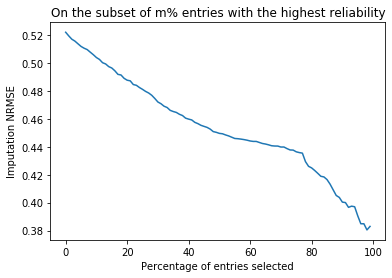

In [12]:
fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Reliability for ordinal data under full rank Gaussian copula model

### Ordinal variables with ratings 1-5

In [13]:
var_types = {'cont':[], 'ord':list(range(15)), 'bin':[]}

In [14]:
sigma = generate_sigma(seed, p=sum([len(value) for value in var_types.values()]))
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask(X, mask_fraction=0.4, seed=seed)

In [15]:
model = GaussianCopula()
out = model.impute_missing(X=X_masked,verbose=True)

Copula correlation change ratio:  0.1279
Copula correlation change ratio:  0.0832
Copula correlation change ratio:  0.0531
Copula correlation change ratio:  0.0346
Copula correlation change ratio:  0.0233
Copula correlation change ratio:  0.0163
Copula correlation change ratio:  0.0118
Convergence at iteration 8


In [16]:
get_mae(x_imp = out['imputed_data'], x_true = X, x_obs = X_masked)

0.42691666666666667

The default setting of evaluation computes the imputation error in the grid of 100 points. It could happen sometimes the entries with very high reliability (a few top percentiles) are in fact, as shown below.

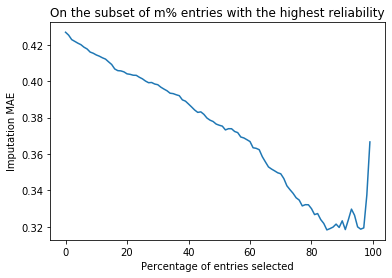

In [17]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=out['imputed_data'])

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

If we sample smaller number of points in the grid such that each point is evaluated with more data points, the curve looks good again.

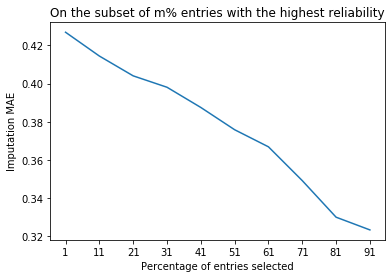

In [18]:
mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=out['imputed_data'], num=10)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')
_ = ax.set_xticks(list(range(10)))
_ = ax.set_xticklabels([str(x+1) for x in range(0, 100, 10)])

### Binary variables

In [19]:
var_types = {'cont':[], 'ord':[], 'bin':list(range(15))}

sigma = generate_sigma(seed, p=sum([len(value) for value in var_types.values()]))
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask(X, mask_fraction=0.4, seed=seed)

In [20]:
model = GaussianCopula()
out = model.impute_missing(X=X_masked,verbose=True)

Copula correlation change ratio:  0.0991
Copula correlation change ratio:  0.0779
Copula correlation change ratio:  0.0585
Copula correlation change ratio:  0.0428
Copula correlation change ratio:  0.0308
Copula correlation change ratio:  0.022
Copula correlation change ratio:  0.0157
Copula correlation change ratio:  0.0113
Convergence at iteration 9


In [21]:
get_mae(x_imp = out['imputed_data'], x_true = X, x_obs = X_masked)

0.31425

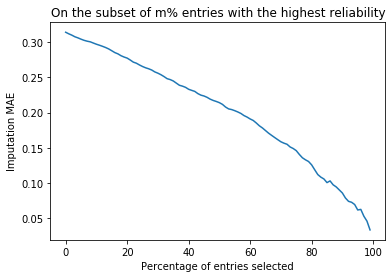

In [22]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=out['imputed_data'])

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Confidence interval under low rank Gaussian copula model

We use a 500*200 dimensional dataset generated from the low rank Gaussian copula model whose marginals are cubic of standard normals. The coverage results are robust to different marginal distribution specification.

In [23]:
seed = 101
var_types = {'cont':list(range(200)), 'ord':[], 'bin':[]}

In [24]:
X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask(X, mask_fraction = 0.4, seed=seed)

In [25]:
model = LowRankGaussianCopula()
out = model.impute_missing(X=X_masked, rank=10, verbose=True)

Ater initialization, W has shape (200, 10) and sigma is 0.13660508507418753
Interation 1: sigma estimate 0.105, copula  parameter change ratio 0.064, likelihood 85624.238
Interation 2: sigma estimate 0.100, copula  parameter change ratio 0.006, likelihood 98433.576
Interation 3: sigma estimate 0.099, copula  parameter change ratio 0.003, likelihood 100624.374
early stop because changed likelihood below 1%


In [26]:
get_rmse(x_imp = out['imputed_data'], x_true = X, x_obs = X_masked, relative = True)

0.5177723167413107

In [27]:
cover_rate = {}
for alpha in [0.85, 0.9, 0.95]:
    out_confidence_interval = model.get_imputed_confidence_interval(alpha = alpha)
    missing_loc = np.isnan(X_masked)
    lower, upper = out_confidence_interval['lower'], out_confidence_interval['upper']
    cover = (lower[missing_loc] < X[missing_loc]) & (upper[missing_loc] > X[missing_loc])
    cover_rate[alpha] = np.array(cover).mean()

The returned confidence intervals are slightly lower than the specified coverage rate

In [28]:
for key, val in cover_rate.items():
    print(f'The actual coverage rate is {val:.3f} with specified coverage rate {key:.3f}')

The actual coverage rate is 0.824 with specified coverage rate 0.850
The actual coverage rate is 0.875 with specified coverage rate 0.900
The actual coverage rate is 0.930 with specified coverage rate 0.950


## Reliability for continuous data under low rank Gaussian copula model

In [29]:
reliability = model.get_reliability(Ximp = out['imputed_data'])

In [30]:
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=out['imputed_data'])

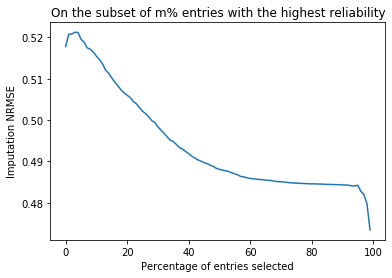

In [31]:
fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Reliability for ordinal data under low rank Gaussian copula model

### Ordinal variables with ratings 1-5

In [32]:
var_types = {'cont':[], 'ord':list(range(200)), 'bin':[]}

X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask(X, mask_fraction = 0.4, seed=seed)

In [33]:
model = LowRankGaussianCopula()
out = model.impute_missing(X=X_masked, rank=10, verbose=True)

Ater initialization, W has shape (200, 10) and sigma is 0.2108259005080522
Interation 1: sigma estimate 0.157, copula  parameter change ratio 0.068, likelihood 63134.733
Interation 2: sigma estimate 0.134, copula  parameter change ratio 0.025, likelihood 79732.018
Interation 3: sigma estimate 0.122, copula  parameter change ratio 0.012, likelihood 87671.367
Interation 4: sigma estimate 0.115, copula  parameter change ratio 0.007, likelihood 92296.471
Interation 5: sigma estimate 0.110, copula  parameter change ratio 0.005, likelihood 95276.407
Interation 6: sigma estimate 0.107, copula  parameter change ratio 0.003, likelihood 97318.665
Interation 7: sigma estimate 0.105, copula  parameter change ratio 0.002, likelihood 98776.259
Interation 8: sigma estimate 0.103, copula  parameter change ratio 0.002, likelihood 99845.668
early stop because changed likelihood below 1%


In [34]:
get_mae(x_imp = out['imputed_data'], x_true = X, x_obs = X_masked)

0.2382

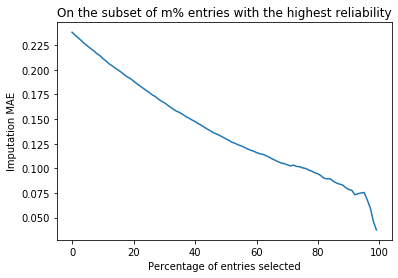

In [35]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=out['imputed_data'])

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

### Binary variables

In [36]:
var_types = {'cont':[], 'ord':[], 'bin':list(range(200))}

X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask(X, mask_fraction = 0.4, seed=seed)

In [37]:
model = LowRankGaussianCopula()
out = model.impute_missing(X=X_masked, rank=10, verbose=True)

Ater initialization, W has shape (200, 10) and sigma is 0.3080028454415014
Interation 1: sigma estimate 0.226, copula  parameter change ratio 0.103, likelihood 46954.226
Interation 2: sigma estimate 0.185, copula  parameter change ratio 0.042, likelihood 62863.094
Interation 3: sigma estimate 0.164, copula  parameter change ratio 0.024, likelihood 72892.427
Interation 4: sigma estimate 0.150, copula  parameter change ratio 0.015, likelihood 79015.950
Interation 5: sigma estimate 0.141, copula  parameter change ratio 0.011, likelihood 83221.214
Interation 6: sigma estimate 0.134, copula  parameter change ratio 0.008, likelihood 86296.475
Interation 7: sigma estimate 0.130, copula  parameter change ratio 0.006, likelihood 88631.599
Interation 8: sigma estimate 0.126, copula  parameter change ratio 0.005, likelihood 90447.496
Interation 9: sigma estimate 0.123, copula  parameter change ratio 0.004, likelihood 91881.640
Interation 10: sigma estimate 0.120, copula  parameter change ratio 0.

In [ ]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=out['imputed_data'])

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')